Training Baseline MLP...
Epoch 1/10 - Loss: 0.1665, MAE: 0.1524, RMSE: 0.2006
Epoch 2/10 - Loss: 0.0159, MAE: 0.0863, RMSE: 0.0930
Epoch 3/10 - Loss: 0.0078, MAE: 0.0881, RMSE: 0.0979
Epoch 4/10 - Loss: 0.0070, MAE: 0.0952, RMSE: 0.1039
Epoch 5/10 - Loss: 0.0061, MAE: 0.0532, RMSE: 0.0552
Epoch 6/10 - Loss: 0.0058, MAE: 0.0715, RMSE: 0.0808
Epoch 7/10 - Loss: 0.0055, MAE: 0.0557, RMSE: 0.0687
Epoch 8/10 - Loss: 0.0053, MAE: 0.0737, RMSE: 0.0761
Epoch 9/10 - Loss: 0.0052, MAE: 0.0757, RMSE: 0.0811
Epoch 10/10 - Loss: 0.0052, MAE: 0.0662, RMSE: 0.0706


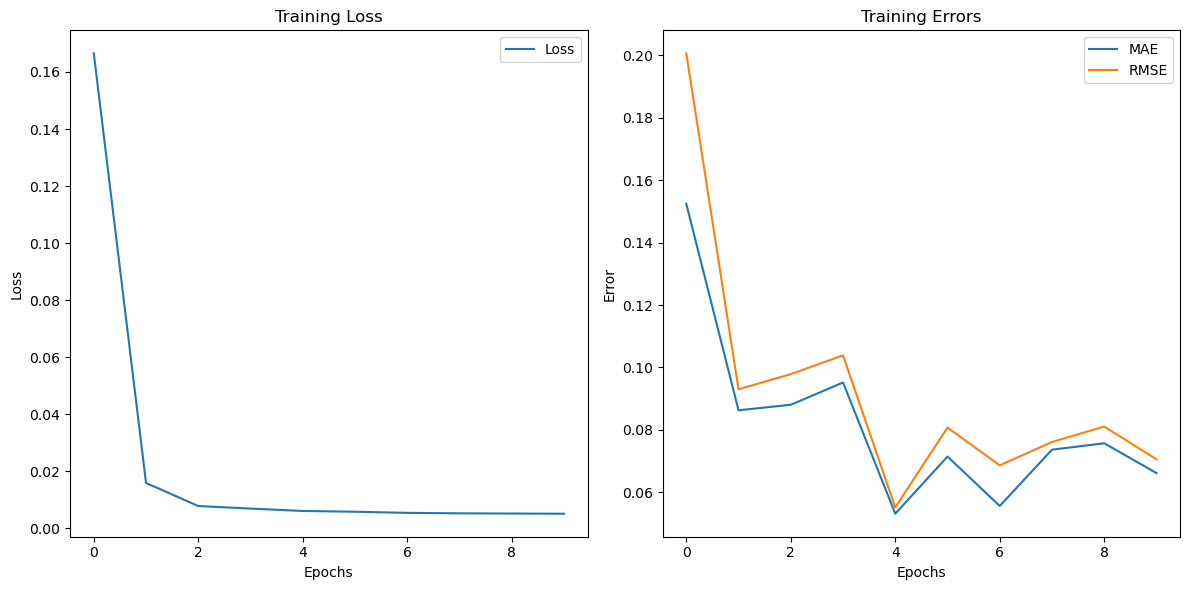

In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Define basic components of DRAGON framework

class DAG:
    def __init__(self):
        self.nodes = []
        self.edges = {}

    def add_node(self, operation):
        node_id = len(self.nodes)
        self.nodes.append(operation)
        self.edges[node_id] = []
        return node_id

    def add_edge(self, from_node, to_node):
        if to_node not in self.edges[from_node]:
            self.edges[from_node].append(to_node)

    def forward(self, x):
        outputs = {}
        for node_id, operation in enumerate(self.nodes):
            inputs = [outputs[i] for i in self.edges if node_id in self.edges[i]]
            inputs = torch.cat(inputs, dim=1) if inputs else x
            outputs[node_id] = operation(inputs)
        return outputs[len(self.nodes) - 1]

# Define a sample node operation class
class MLPNode(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPNode, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.fc(x))

class Conv1DNode(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv1DNode, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.conv(x)
        x = x.squeeze(1)  # Remove channel dimension after Conv1D
        return self.activation(x)

class AttentionNode(nn.Module):
    def __init__(self, input_size):
        super(AttentionNode, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_size, num_heads=2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x, _ = self.attention(x, x, x)
        x = x.squeeze(1)  # Remove sequence dimension
        return x

# Baseline Models
class BaselineMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaselineMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return self.fc2(x)

class BaselineCNN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size, output_size):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, num_channels, kernel_size)
        self.activation = nn.ReLU()
        self.fc = nn.Linear((input_size - kernel_size + 1) * num_channels, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.activation(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Define evolutionary algorithm components

def mutate_dag(dag):
    """Example mutation: Add a new node and connect it."""
    new_node_type = random.choice([MLPNode, Conv1DNode, AttentionNode])
    if new_node_type == MLPNode:
        new_node = new_node_type(input_size=10, output_size=10)  # Matching input/output size
    elif new_node_type == Conv1DNode:
        new_node = new_node_type(in_channels=1, out_channels=1, kernel_size=3)
    elif new_node_type == AttentionNode:
        new_node = new_node_type(input_size=10)  # Adjusted input size
    new_node_id = dag.add_node(new_node)
    from_node = random.choice(range(len(dag.nodes) - 1))
    dag.add_edge(from_node, new_node_id)
    return dag

def crossover_dag(parent1, parent2):
    """Example crossover: Exchange random nodes."""
    child = DAG()
    split_point = len(parent1.nodes) // 2
    for i in range(len(parent1.nodes)):
        child.add_node(parent1.nodes[i] if i < split_point else parent2.nodes[i])
    for from_node, to_nodes in parent1.edges.items():
        if from_node < split_point:
            for to_node in to_nodes:
                if to_node < split_point:
                    child.add_edge(from_node, to_node)
    return child

# Example dataset preparation
def generate_synthetic_data():
    X = np.random.rand(1000, 10)
    y = np.random.rand(1000, 1)
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=32, shuffle=True)

# Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Example training process
def train_model(model, dataloader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    losses = []
    maes = []
    rmses = []

    for epoch in range(epochs):
        epoch_losses = []
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        # Compute metrics on the last batch for simplicity
        mae, rmse = compute_metrics(y_batch, outputs)
        maes.append(mae)
        rmses.append(rmse)

        # Record average loss for the epoch
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    return losses, maes, rmses

# Visualization
def plot_training_metrics(losses, maes, rmses):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(maes, label='MAE')
    plt.plot(rmses, label='RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training Errors')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Advanced: Time Series Dataset Handling
def preprocess_time_series_data():
    """Placeholder for time series data preprocessing."""
    # Replace with actual data loading and preprocessing code.
    X = np.sin(np.linspace(0, 100, 1000))  # Example sinusoidal data
    y = np.roll(X, -1)  # Predict the next time step
    X = X[:-1]  # Ensure matching dimensions
    y = y[:-1]  # Ensure matching dimensions
    dataset = TensorDataset(
        torch.tensor(X.reshape(-1, 1), dtype=torch.float32),  # Reshape each sample to 1 feature
        torch.tensor(y.reshape(-1, 1), dtype=torch.float32),
    )
    return DataLoader(dataset, batch_size=32, shuffle=True)

def main():
    # Generate data
    dataloader = preprocess_time_series_data()

    # Train Baseline MLP
    print("Training Baseline MLP...")
    input_size = 1  # Set input size based on data shape (e.g., 1 feature for time series)
    hidden_size = 64  # Example hidden size
    output_size = 1  # Output size for regression task
    baseline_mlp = BaselineMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

    # Train the model
    losses, maes, rmses = train_model(baseline_mlp, dataloader, epochs=10)

    # Plot training metrics
    plot_training_metrics(losses, maes, rmses)

if __name__ == "__main__":
    main()

